In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Code by Ness Campagna, assisted with Claude AI (especially the error handling and formatting)

# Visualizations description
# 1. radar chart showcasing how much a given instrument has a presence across different songs / playlists.
#    for example, high energy playlists with high energy songs may have more kick and bass. 
# 2. emotional landscape, with valence (negative to positive emotion) being the x axis
#    and arousal (calm to energetic) on the y. divided into quadrants for convenience. 
# 3. violin chart - does a playlist/song have a consistent energy level? how are factors distributed.
#    also, what "type" of energy is present?
# 4. feature importance heatmap - hierarchical clustering where playlist/songs as a whole are grouped and
#    so are related features. shows similarity to identify patterns at a glance.
# 5. 3D space visualization to compare across three audio features. centroids to compare clusters 
#    between different types of music styles / playlists. 

In [2]:
file_path = 'processed_dataset.csv'

try:
    # load csv
    songs_df = pd.read_csv(file_path)
    print(f"Successfully loaded dataset with {songs_df.shape[0]} songs and {songs_df.shape[1]} features.")
    
    # preview
    print(songs_df.head())
    
    # ai suggested file handling
except Exception as e:
    print(f"Error loading data: {e}")
    print("\nIf you're getting an error, please check the following:")
    print("1. Make sure the file path is correct")
    print("2. Ensure the CSV file exists and is not corrupted")
    print("3. Verify you have permission to read the file")
    raise

Successfully loaded dataset with 47623 songs and 177 features.
   song_id  Duration_Seconds  Estimated_Key  Key_Confidence  Average_Pitch  \
0        0          0.070309       0.192308        0.856629       0.644289   
1        1          0.081901       0.653846        0.826805       0.669634   
2        2          0.090745       0.153846        0.794996       0.462996   
3        3          0.089588       0.153846        0.616232       0.489840   
4        4          0.095935       0.000000        0.899950       0.441082   

   Pitch_Std  Pitch_Range  pYIN_Mean_Pitch  pYIN_Pitch_Std  pYIN_Pitch_Range  \
0   0.717388     0.999959         0.091359        0.424917          0.908875   
1   0.712604     0.999998         0.032634        0.083520          0.204388   
2   0.569764     0.999987         0.054273        0.061121          0.133154   
3   0.660930     0.999980         0.028305        0.030815          0.106035   
4   0.540318     0.999905         0.018929        0.080356          

In [7]:
# dummy playlists based on different music characteristics
# feel free to swap out with actual playlists
# assumes that a given playlist has a consistent feel - people don't put sad songs in their happy playlists.

def create_dummy_playlists(df, num_playlists=5, songs_per_playlist=20):
    playlists = {}
    
    # df has a copy of song_id as index for easier lookups
    df = df.copy()
    if 'song_id' in df.columns:
        df = df.set_index('song_id', drop=False)
        
    # high energy playlist - high tempo, high arousal
    if all(col in df.columns for col in ['Tempo_BPM', 'Emotional_Arousal']):
        df['energy_score'] = df['Tempo_BPM'] / df['Tempo_BPM'].max() * 0.5 + df['Emotional_Arousal'] * 0.5
        high_energy_ids = df.sort_values(by='energy_score', ascending=False).head(songs_per_playlist)['song_id'].tolist()
        playlists["High Energy Workout"] = high_energy_ids
        
    # chill vibes playlist - medium-low tempo, high valence, low arousal
    if all(col in df.columns for col in ['Tempo_BPM', 'Emotional_Valence', 'Emotional_Arousal']):
        df['chill_score'] = (
            df['Emotional_Valence'] * 0.6 + 
            (1 - df['Emotional_Arousal']) * 0.3 + 
            (1 - (df['Tempo_BPM'] / df['Tempo_BPM'].max())) * 0.1
        )
        chill_ids = df.sort_values(by='chill_score', ascending=False).head(songs_per_playlist)['song_id'].tolist()
        playlists["Chill Vibes"] = chill_ids
    
    # dance party playlist - high tempo, strong beat, percussive
    if all(col in df.columns for col in ['Tempo_BPM', 'Beat_Strength']):
        dance_cols = ['Tempo_BPM', 'Beat_Strength']
        if 'Percussive_Energy' in df.columns:
            dance_cols.append('Percussive_Energy')
        
        for col in dance_cols:
            df[f'{col}_norm'] = df[col] / df[col].max()
        
        df['dance_score'] = df[[f'{col}_norm' for col in dance_cols]].mean(axis=1)
        dance_ids = df.sort_values(by='dance_score', ascending=False).head(songs_per_playlist)['song_id'].tolist()
        playlists["Dance Party"] = dance_ids
    
    # focus / study playlist - moderate complexity, low arousal, high harmonic content
    focus_cols = []
    if 'Emotional_Arousal' in df.columns:
        focus_cols.append('Emotional_Arousal')
    if 'Spectral_Entropy' in df.columns:
        focus_cols.append('Spectral_Entropy')
    if 'Harmonic_Energy' in df.columns:
        focus_cols.append('Harmonic_Energy')
    
    if focus_cols:
        for col in focus_cols:
            df[f'{col}_norm'] = df[col] / df[col].max()
        
        df['focus_score'] = 0
        if 'Emotional_Arousal_norm' in df.columns:
            df['focus_score'] += (1 - df['Emotional_Arousal_norm']) * 0.4
        if 'Spectral_Entropy_norm' in df.columns:
            df['focus_score'] += (1 - abs(df['Spectral_Entropy_norm'] - 0.5)) * 0.3
        if 'Harmonic_Energy_norm' in df.columns:
            df['focus_score'] += df['Harmonic_Energy_norm'] * 0.3
        
        focus_ids = df.sort_values(by='focus_score', ascending=False).head(songs_per_playlist)['song_id'].tolist()
        playlists["Focus Study"] = focus_ids
    
    # mood boost playlist - high valence
    if 'Emotional_Valence' in df.columns:
        happy_ids = df.sort_values(by='Emotional_Valence', ascending=False).head(songs_per_playlist)['song_id'].tolist()
        playlists["Mood Boost"] = happy_ids
    
    # Create a DataFrame with playlist assignments for easier analysis
    playlist_df = pd.DataFrame()
    for playlist_name, song_ids in playlists.items():
        temp_df = pd.DataFrame({
            'song_id': song_ids,
            'playlist': playlist_name
        })
        playlist_df = pd.concat([playlist_df, temp_df])
    
    return playlists, playlist_df

In [8]:
# generate the playlists. random but has to fufill a consistent feel for the playlist. 
playlists, playlist_df = create_dummy_playlists(songs_df)

print("\nGenerated the following playlists:")
for playlist_name, song_ids in playlists.items():
    print(f"{playlist_name}: {len(song_ids)} songs")

# crosscheck what it chose
print("\nSong IDs in each playlist:")
for playlist_name, song_ids in playlists.items():
    print(f"\n{playlist_name} playlist songs:")
    print(", ".join(map(str, song_ids)))


Generated the following playlists:
High Energy Workout: 20 songs
Chill Vibes: 20 songs
Dance Party: 20 songs
Focus Study: 20 songs
Mood Boost: 20 songs

Song IDs in each playlist:

High Energy Workout playlist songs:
24298, 2282, 45814, 17998, 19412, 14743, 14706, 10014, 10389, 10368, 41934, 4549, 4543, 41937, 20789, 47176, 1421, 35062, 43956, 27558

Chill Vibes playlist songs:
12750, 9435, 21219, 8893, 26487, 32180, 2804, 22482, 44322, 21214, 14885, 42264, 42146, 7482, 24233, 22471, 25256, 16794, 35360, 6508

Dance Party playlist songs:
17998, 19412, 10086, 45814, 19288, 10013, 11131, 44094, 41864, 14668, 9535, 13330, 13345, 14750, 14721, 25693, 10014, 44113, 2282, 30601

Focus Study playlist songs:
8521, 27536, 27560, 8553, 8549, 8548, 8527, 26237, 19730, 25462, 25312, 34151, 29971, 25291, 25494, 19735, 25381, 34113, 8524, 25479

Mood Boost playlist songs:
12750, 11606, 33158, 6508, 7407, 31089, 22482, 13005, 7391, 3777, 3538, 3599, 3604, 28648, 3608, 42146, 42264, 21545, 21794, 313

In [9]:
# merge playlist information with song data
playlist_songs_df = playlist_df.merge(songs_df, on='song_id', how='left')

In [10]:
# assign colors to playlists consistently
def get_playlist_colors(playlist_names):
    """Return a dict mapping playlist names to colors"""
    color_palette = sns.color_palette("tab10", len(playlist_names))
    return {name: color_palette[i] for i, name in enumerate(playlist_names)}

playlist_colors = get_playlist_colors(playlist_df['playlist'].unique())



Visualization 1: Instrument Presence Comparison


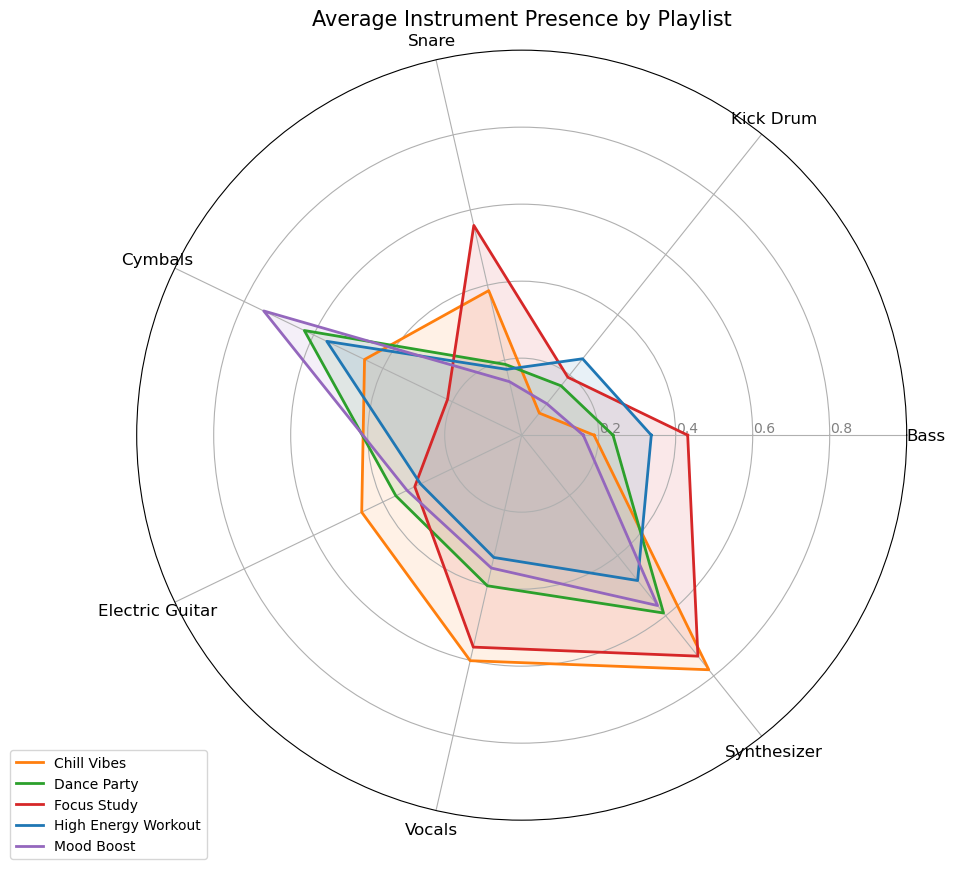

In [12]:
print("\n\nVisualization 1: Instrument Presence Comparison")

try:
    # do necessary columns exist?
    instrument_columns = [
        'bass_presence', 'kick_drum_presence', 'snare_presence', 
        'cymbals_presence', 'electric_guitar_presence', 
        'vocals_presence', 'synthesizer_presence'
    ]
    
    # which instrument columns are available in our dataset
    available_instrument_cols = [col for col in instrument_columns if col in songs_df.columns]
    
    if available_instrument_cols:
        # format
        categories = [col.replace('_presence', '').replace('_', ' ').title() for col in available_instrument_cols]
        
        # average instrument presence for each playlist
        playlist_avg = playlist_songs_df.groupby('playlist')[available_instrument_cols].mean()
        
        fig = plt.figure(figsize=(14, 10))
        
        N = len(categories)
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop
        
        ax = plt.subplot(111, polar=True)
        
        plt.xticks(angles[:-1], categories, size=12)
        
        ax.set_rlabel_position(0)
        plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
        plt.ylim(0, 1)
        
        # plot each playlist
        for playlist_name in playlist_avg.index:
            values = playlist_avg.loc[playlist_name, available_instrument_cols].values.tolist()
            values += values[:1]
            
            ax.plot(angles, values, linewidth=2, linestyle='solid', 
                    label=playlist_name, color=playlist_colors[playlist_name])
            ax.fill(angles, values, alpha=0.1, color=playlist_colors[playlist_name])
        
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        
        plt.title('Average Instrument Presence by Playlist', size=15)
        plt.show()
    else:
        print(f"Cannot create Instrument Presence Comparison: No instrument columns available in dataset")            
except Exception as e:
    print(f"Error creating Instrument Presence Comparison: {e}")



Visualization 2: Emotional Landscape by Playlist


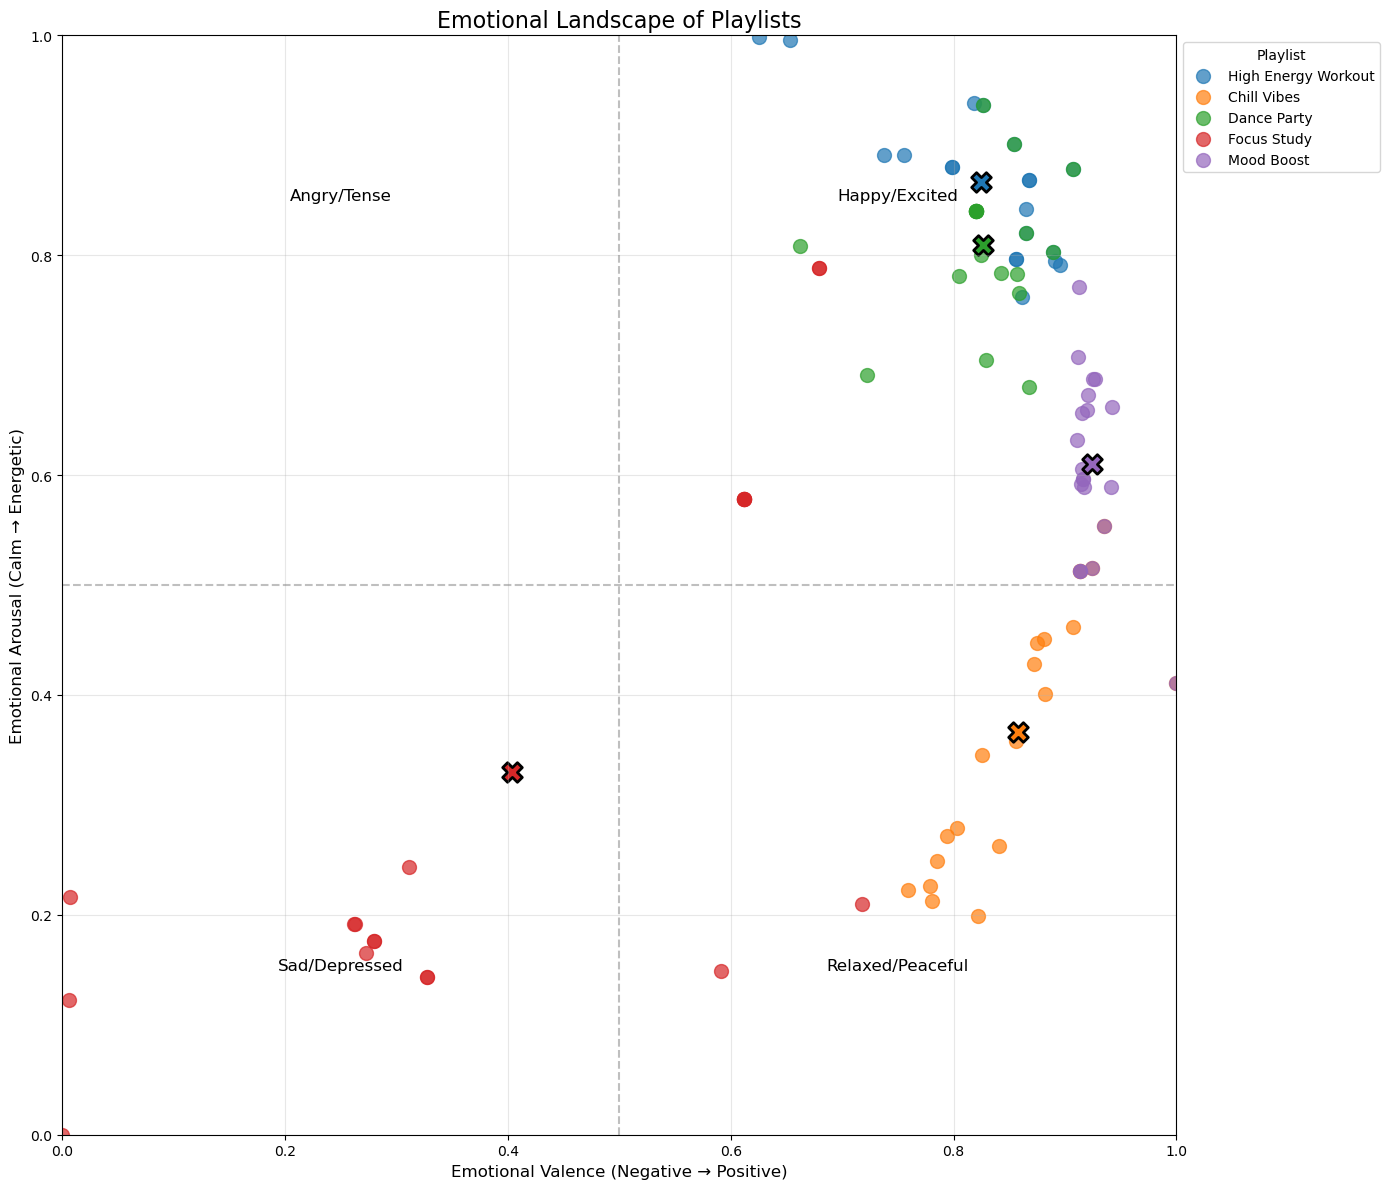

In [13]:
print("\n\nVisualization 2: Emotional Landscape by Playlist")

try:
    # do necessary columns exist?
    required = ['Emotional_Valence', 'Emotional_Arousal']
    if all(col in songs_df.columns for col in required):
        plt.figure(figsize=(14, 12))
        
        # playlists have unique colors
        for playlist_name in playlist_songs_df['playlist'].unique():
            playlist_data = playlist_songs_df[playlist_songs_df['playlist'] == playlist_name]
            
            plt.scatter(
                playlist_data['Emotional_Valence'],
                playlist_data['Emotional_Arousal'],
                s=100,
                alpha=0.7,
                color=playlist_colors[playlist_name],
                label=playlist_name
            )
        
        plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
        
        plt.text(0.25, 0.85, 'Angry/Tense', fontsize=12, ha='center')
        plt.text(0.75, 0.85, 'Happy/Excited', fontsize=12, ha='center')
        plt.text(0.25, 0.15, 'Sad/Depressed', fontsize=12, ha='center')
        plt.text(0.75, 0.15, 'Relaxed/Peaceful', fontsize=12, ha='center')
        
        # add playlist centroids
        for playlist_name in playlist_songs_df['playlist'].unique():
            playlist_data = playlist_songs_df[playlist_songs_df['playlist'] == playlist_name]
            centroid_x = playlist_data['Emotional_Valence'].mean()
            centroid_y = playlist_data['Emotional_Arousal'].mean()
            
            plt.scatter(
                centroid_x, centroid_y,
                marker='X', s=200, 
                color=playlist_colors[playlist_name],
                edgecolor='black', linewidth=2
            )
        
        plt.xlabel('Emotional Valence (Negative → Positive)', fontsize=12)
        plt.ylabel('Emotional Arousal (Calm → Energetic)', fontsize=12)
        plt.title('Emotional Landscape of Playlists', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        valence_min = max(0, playlist_songs_df['Emotional_Valence'].min() - 0.05)
        valence_max = min(1, playlist_songs_df['Emotional_Valence'].max() + 0.05)
        arousal_min = max(0, playlist_songs_df['Emotional_Arousal'].min() - 0.05)
        arousal_max = min(1, playlist_songs_df['Emotional_Arousal'].max() + 0.05)
        
        plt.xlim(valence_min, valence_max)
        plt.ylim(arousal_min, arousal_max)
        
        plt.legend(title="Playlist", loc="upper left", bbox_to_anchor=(1, 1))
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Cannot create Emotional Landscape: Missing columns {[col for col in required if col not in songs_df.columns]}")
except Exception as e:
    print(f"Error creating Emotional Landscape: {e}")



Visualization 3: Energy Profile Comparison


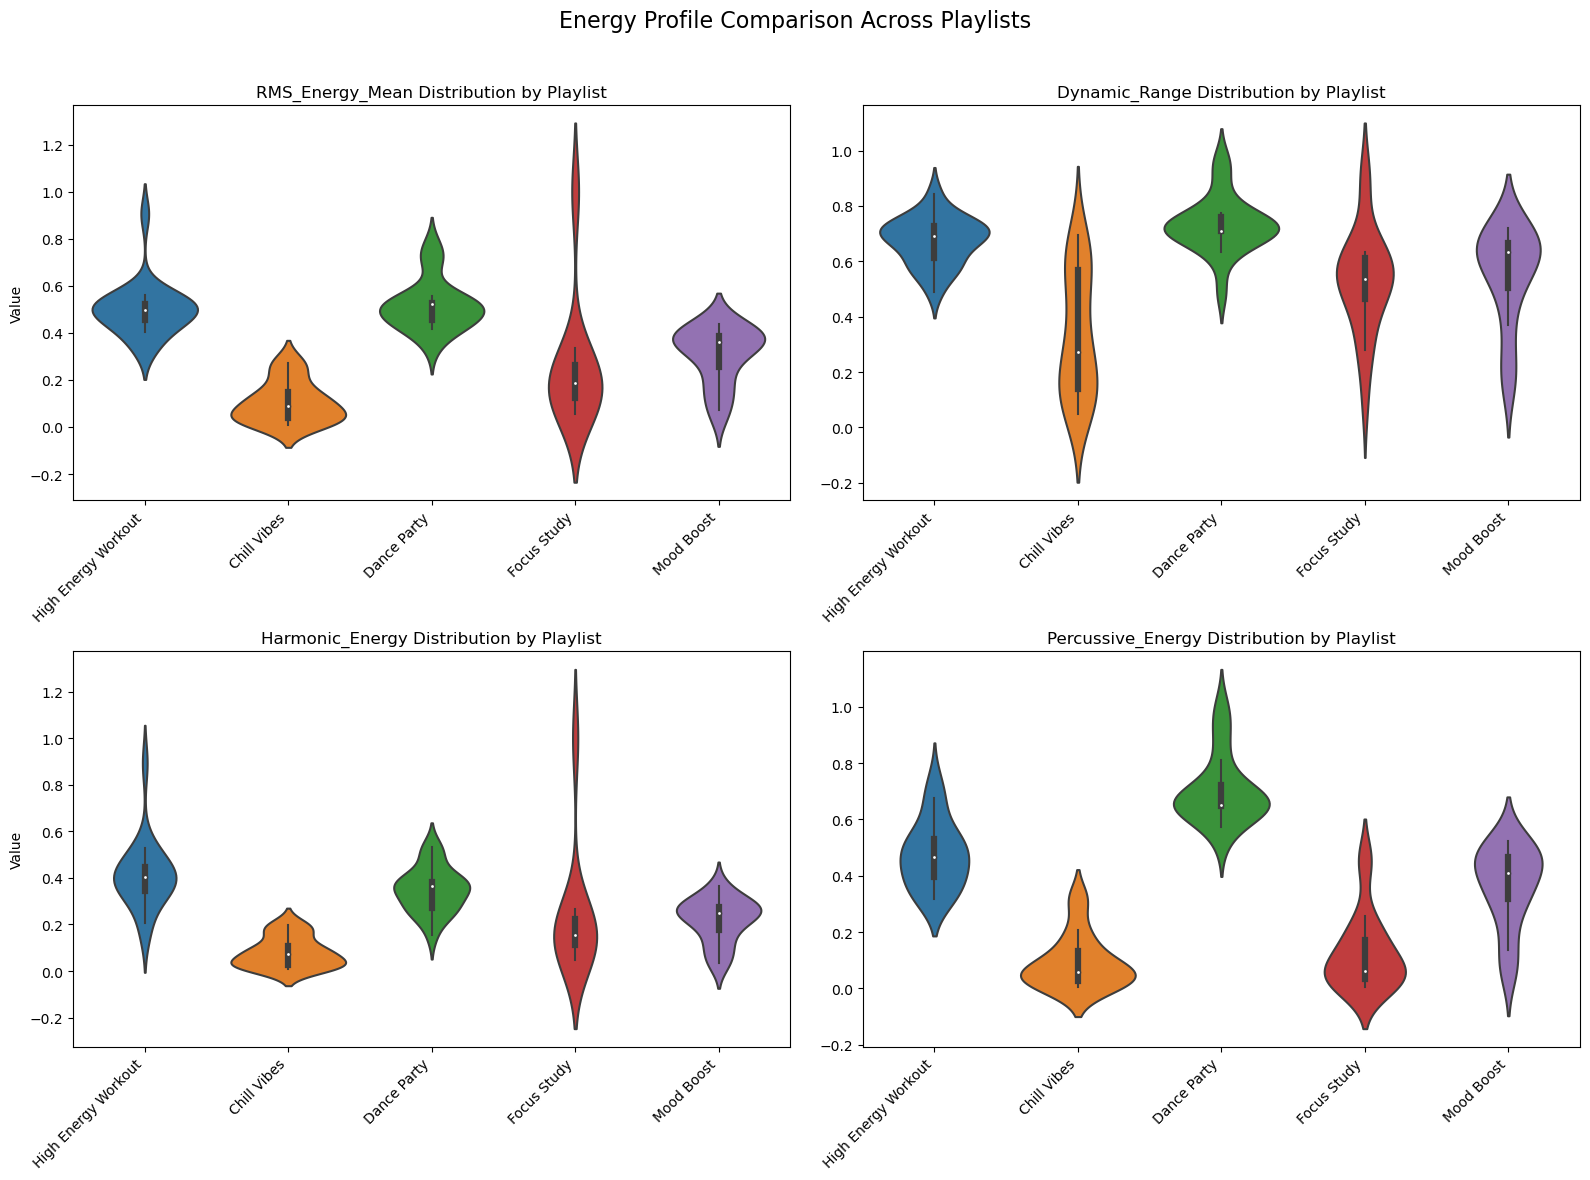


Creating summarized energy profile...


<Figure size 1200x800 with 0 Axes>

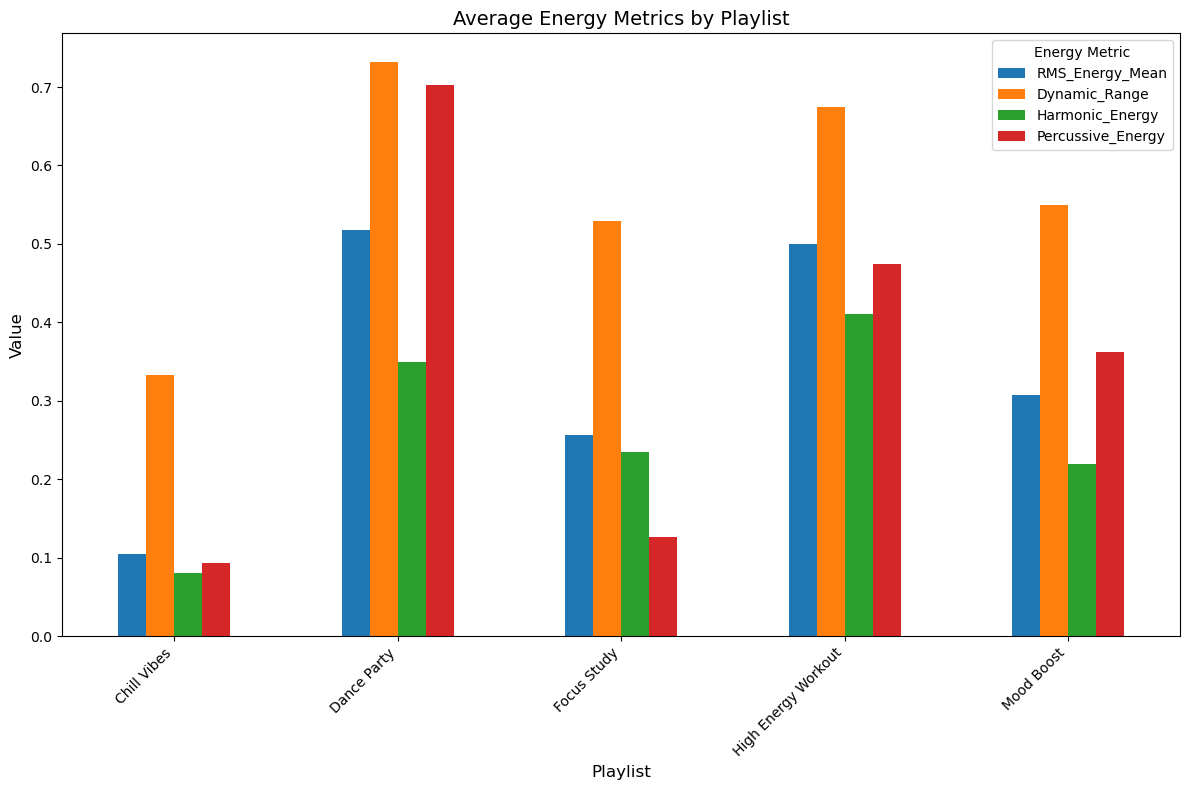

In [14]:
print("\n\nVisualization 3: Energy Profile Comparison")

try:
    # do necessary columns exist?
    energy_columns = [
        'RMS_Energy_Mean', 'Dynamic_Range', 'Harmonic_Energy', 'Percussive_Energy'
    ]
    
    available_energy_cols = [col for col in energy_columns if col in songs_df.columns]
    
    if available_energy_cols:
        plt.figure(figsize=(16, 12))
        
        n_cols = 2
        n_rows = (len(available_energy_cols) + 1) // n_cols
        
        for i, feature in enumerate(available_energy_cols):
            plt.subplot(n_rows, n_cols, i+1)
            
            try:
                sns.violinplot(
                    x='playlist', 
                    y=feature, 
                    data=playlist_songs_df,
                    palette=playlist_colors,
                    inner='box'
                )
            except ValueError:
                # if a violinplot fails (e.g., too few data points), try boxplot <- claude.ai suggested
                sns.boxplot(
                    x='playlist', 
                    y=feature, 
                    data=playlist_songs_df,
                    palette=playlist_colors
                )
            
            plt.title(f'{feature} Distribution by Playlist', fontsize=12)
            plt.xlabel('')
            plt.xticks(rotation=45, ha='right')
            
            if i % n_cols == 0:
                plt.ylabel('Value', fontsize=10)
            else:
                plt.ylabel('')
        
        plt.suptitle('Energy Profile Comparison Across Playlists', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        print("\nCreating summarized energy profile...")
        
        energy_summary = playlist_songs_df.groupby('playlist')[available_energy_cols].mean()
        
        # create the plot
        plt.figure(figsize=(12, 8))
        energy_summary.plot(kind='bar', figsize=(12, 8))
        plt.title('Average Energy Metrics by Playlist', fontsize=14)
        plt.ylabel('Value', fontsize=12)
        plt.xlabel('Playlist', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title="Energy Metric")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Cannot create Energy Profile Comparison: No energy columns available in dataset")
except Exception as e:
    print(f"Error creating Energy Profile Comparison: {e}")




Visualization 4: Feature Importance Heatmap with Hierarchical Clustering


<Figure size 1800x1000 with 0 Axes>

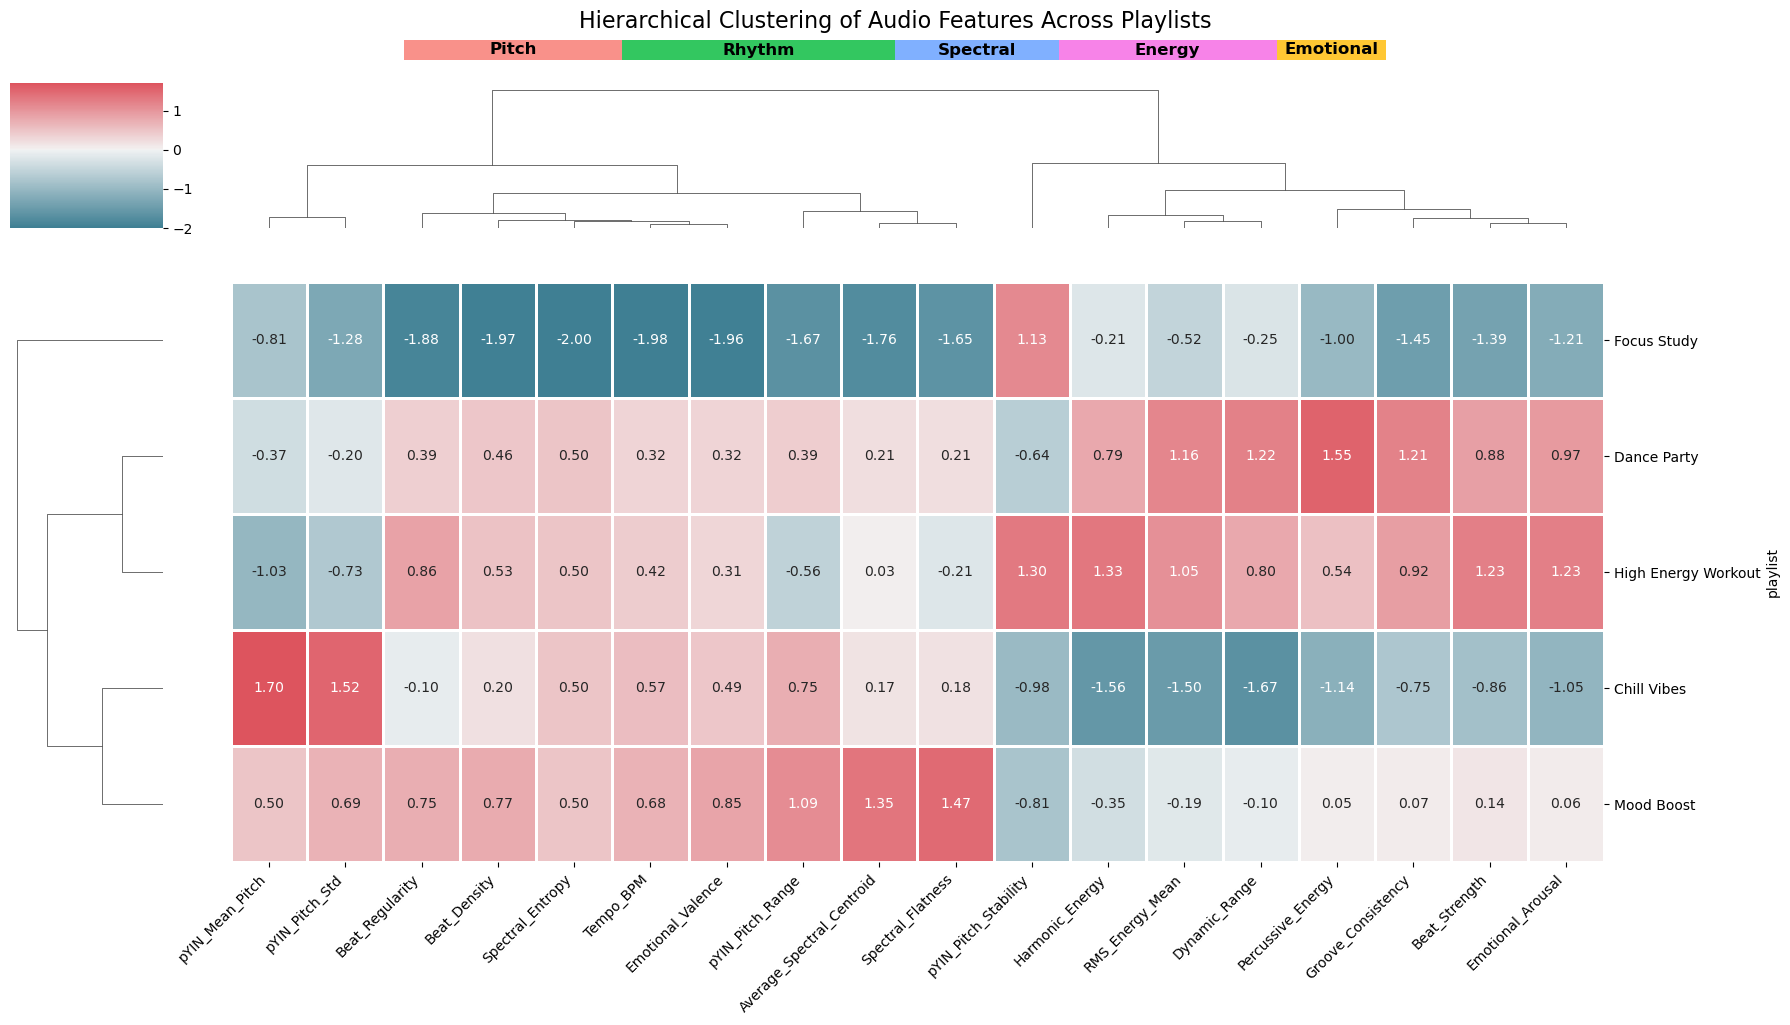

In [17]:
print("\n\nVisualization 4: Feature Importance Heatmap with Hierarchical Clustering")

try:
    feature_categories = {
        'Pitch': ['pYIN_Mean_Pitch', 'pYIN_Pitch_Std', 'pYIN_Pitch_Range', 'pYIN_Pitch_Stability'],
        'Rhythm': ['Tempo_BPM', 'Beat_Regularity', 'Beat_Density', 'Beat_Strength', 'Groove_Consistency'],
        'Spectral': ['Average_Spectral_Centroid', 'Spectral_Entropy', 'Spectral_Flatness'],
        'Energy': ['RMS_Energy_Mean', 'Dynamic_Range', 'Harmonic_Energy', 'Percussive_Energy'],
        'Emotional': ['Emotional_Valence', 'Emotional_Arousal']
    }
    
    available_features = {}
    for category, features in feature_categories.items():
        available = [f for f in features if f in playlist_songs_df.columns]
        if available:
            available_features[category] = available
    
    if available_features:
        all_features = [f for features in available_features.values() for f in features]
        
        playlist_features_avg = playlist_songs_df.groupby('playlist')[all_features].mean()
        
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(playlist_features_avg)
        scaled_df = pd.DataFrame(scaled_data, index=playlist_features_avg.index, columns=all_features)
        
        # heatmap with hierarchical clustering
        plt.figure(figsize=(18, 10))
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        
        g = sns.clustermap(
            scaled_df, 
            cmap=cmap,
            center=0,
            linewidths=0.75, 
            figsize=(18, 10),
            row_cluster=True,
            col_cluster=True,
            dendrogram_ratio=(0.1, 0.2),
            cbar_pos=(0.02, 0.8, 0.05, 0.18),
            method='ward',
            annot=True,
            fmt=".2f"
        )
        
        plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
        g.fig.suptitle('Hierarchical Clustering of Audio Features Across Playlists', fontsize=16, y=1.02)
        
        category_colors = ['#F8766D', '#00BA38', '#619CFF', '#F564E3', '#FFB900']
        category_color_map = {cat: color for cat, color in zip(available_features.keys(), category_colors)}
        
        ax_top = g.fig.add_axes([0.2, 0.97, 0.6, 0.02])
        ax_top.set_axis_off()
        
        x_start = 0
        for i, (category, features) in enumerate(available_features.items()):
            if i < len(category_colors):  
                width = len(features) / len(all_features)
                ax_top.axvspan(x_start, x_start + width, facecolor=category_colors[i], alpha=0.8)
                ax_top.text(x_start + width/2, 0.5, category, 
                           ha='center', va='center', fontsize=12, fontweight='bold')
                x_start += width
        
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough features available for the heatmap visualization")
except Exception as e:
    print(f"Error creating Feature Importance Heatmap: {e}")



Visualization 5: 3D Feature Space Visualization


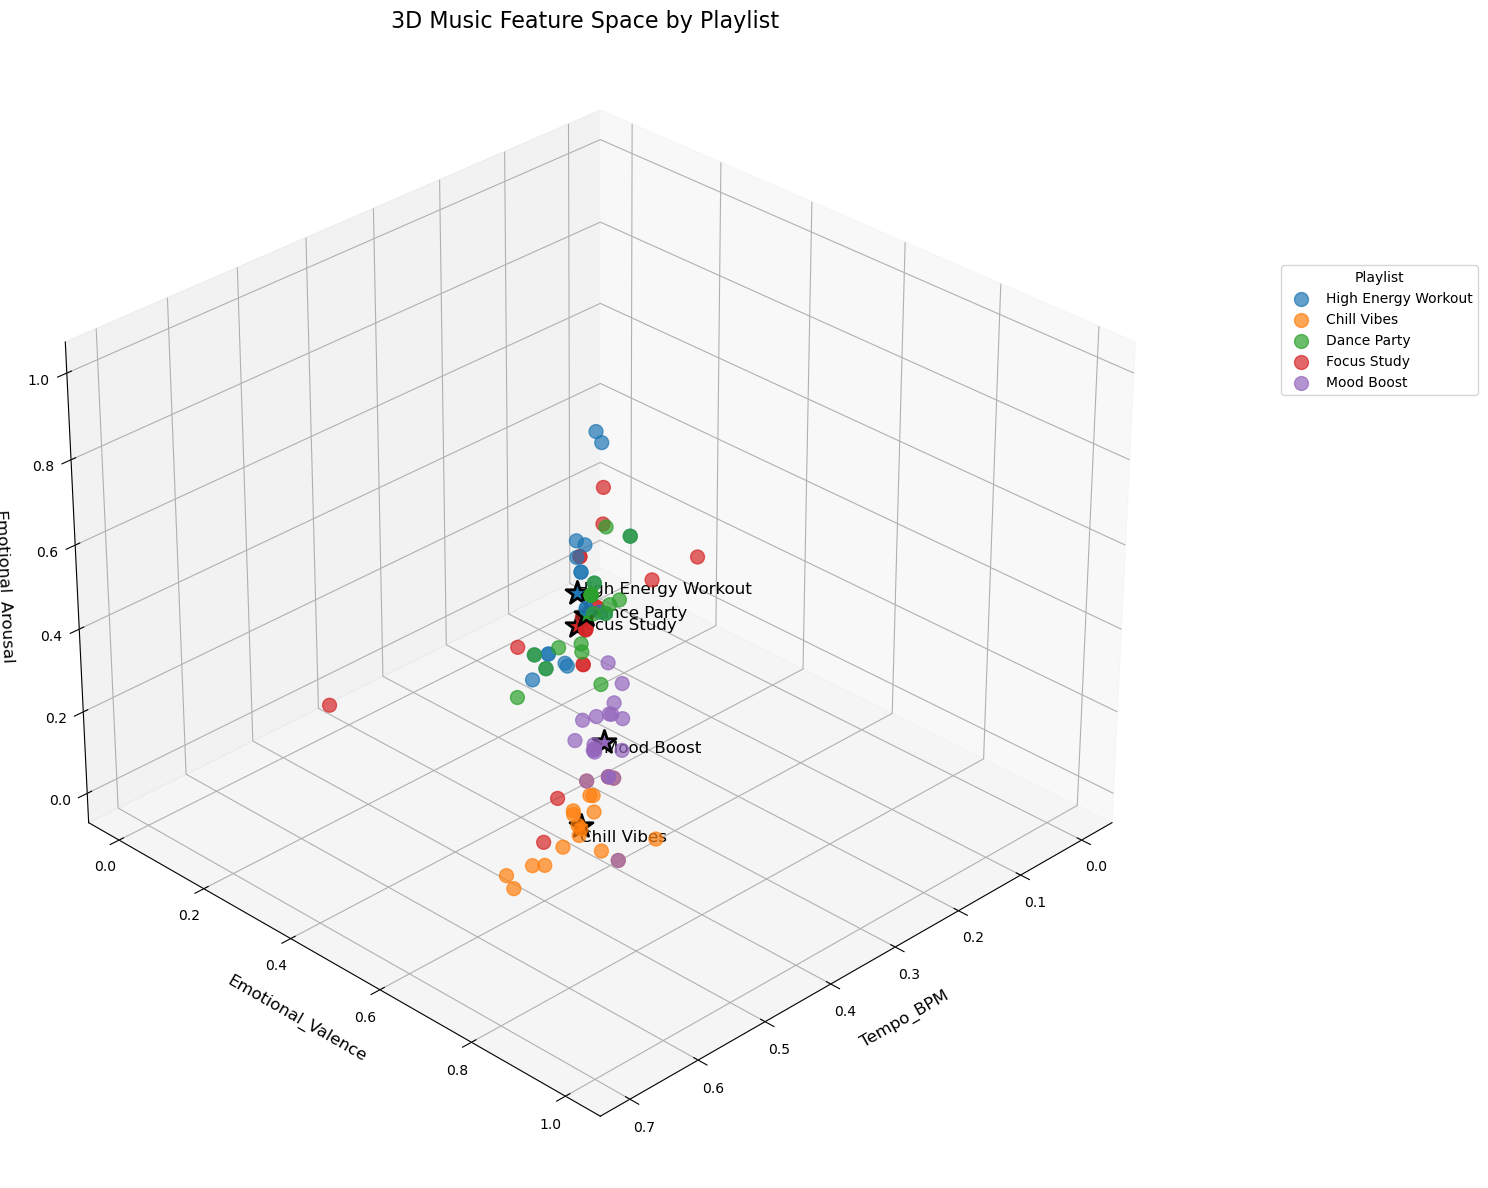

In [18]:
print("\n\nVisualization 5: 3D Feature Space Visualization")

try:
    selected_features = []
    
    important_features = [
        'Tempo_BPM', 'Emotional_Valence', 'Emotional_Arousal',
        'RMS_Energy_Mean', 'Average_Spectral_Centroid', 'Beat_Strength',
        'Harmonic_Ratio', 'Spectral_Entropy'
    ]
    
    for feat in important_features:
        if feat in playlist_songs_df.columns:
            selected_features.append(feat)
            if len(selected_features) == 3:
                break
    
    if len(selected_features) == 3:
        fig = plt.figure(figsize=(14, 12))
        ax = fig.add_subplot(111, projection='3d')
        
        for playlist_name in playlist_songs_df['playlist'].unique():
            playlist_data = playlist_songs_df[playlist_songs_df['playlist'] == playlist_name]
            
            x = playlist_data[selected_features[0]].values
            y = playlist_data[selected_features[1]].values
            z = playlist_data[selected_features[2]].values
            
            ax.scatter(
                x, y, z,
                s=100,
                alpha=0.7,
                color=playlist_colors[playlist_name],
                label=playlist_name
            )
            
            # add playlist centroid
            centroid_x = x.mean()
            centroid_y = y.mean()
            centroid_z = z.mean()
            
            ax.scatter(
                [centroid_x], [centroid_y], [centroid_z],
                marker='*', s=300, 
                color=playlist_colors[playlist_name],
                edgecolor='black', linewidth=2
            )
            
            # add text label for the centroid
            ax.text(centroid_x*1.05, centroid_y*1.05, centroid_z*1.05, 
                   playlist_name, fontsize=12)
        
        ax.set_xlabel(selected_features[0], fontsize=12, labelpad=10)
        ax.set_ylabel(selected_features[1], fontsize=12, labelpad=10)
        ax.set_zlabel(selected_features[2], fontsize=12, labelpad=10)
        
        plt.title('3D Music Feature Space by Playlist', fontsize=16, y=1.08)
        plt.legend(title="Playlist", loc="upper left", bbox_to_anchor=(1.1, 0.8))
        
        ax.view_init(elev=30, azim=45)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough features available for 3D visualization")
except Exception as e:
    print(f"Error creating 3D Feature Space Visualization: {e}")